In [185]:
import torch
import torch.nn as nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

In [12]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

In [3]:
data_path = '../data/p1ch7/'

cifar10 = datasets.CIFAR10(data_path, train=True, download=True)
cifar10_val = datasets.CIFAR10(data_path, train=False, download=True)

100%|██████████| 170498071/170498071 [00:02<00:00, 73786201.75it/s]


Extracting ../data/p1ch7/cifar-10-python.tar.gz to ../data/p1ch7/
Files already downloaded and verified


In [4]:
type(cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [5]:
len(cifar10)

50000

In [14]:
img, label = cifar10[99]
img, label, class_names[label]

(<PIL.Image.Image image mode=RGB size=32x32>, 1, 'automobile')

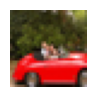

In [20]:
plt.figure(figsize=(1, 1))
plt.imshow(img)
plt.axis('off');

In [22]:
dir(transforms)

['AugMix',
 'AutoAugment',
 'AutoAugmentPolicy',
 'CenterCrop',
 'ColorJitter',
 'Compose',
 'ConvertImageDtype',
 'ElasticTransform',
 'FiveCrop',
 'GaussianBlur',
 'Grayscale',
 'InterpolationMode',
 'Lambda',
 'LinearTransformation',
 'Normalize',
 'PILToTensor',
 'Pad',
 'RandAugment',
 'RandomAdjustSharpness',
 'RandomAffine',
 'RandomApply',
 'RandomAutocontrast',
 'RandomChoice',
 'RandomCrop',
 'RandomEqualize',
 'RandomErasing',
 'RandomGrayscale',
 'RandomHorizontalFlip',
 'RandomInvert',
 'RandomOrder',
 'RandomPerspective',
 'RandomPosterize',
 'RandomResizedCrop',
 'RandomRotation',
 'RandomSolarize',
 'RandomVerticalFlip',
 'Resize',
 'TenCrop',
 'ToPILImage',
 'ToTensor',
 'TrivialAugmentWide',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_functional_pil',
 '_functional_tensor',
 '_presets',
 'autoaugment',
 'functional',
 'transforms']

In [23]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(img)
img_t.shape

torch.Size([3, 32, 32])

In [25]:
tensor_cifar10 = datasets.CIFAR10(data_path, train=True, download=False, transform=transforms.ToTensor())

In [26]:
img_t, _ = tensor_cifar10[99]
type(img_t)

torch.Tensor

In [27]:
img_t.shape, img_t.dtype

(torch.Size([3, 32, 32]), torch.float32)

In [28]:
img_t.min(), img_t.max()

(tensor(0.), tensor(1.))

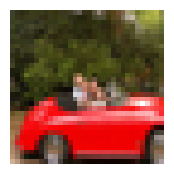

In [31]:
plt.figure(figsize=(2, 2))
plt.imshow(img_t.permute(1, 2, 0))
plt.axis('off');

In [34]:
type(tensor_cifar10).__mro__

(torchvision.datasets.cifar.CIFAR10,
 torchvision.datasets.vision.VisionDataset,
 torch.utils.data.dataset.Dataset,
 typing.Generic,
 object)

In [82]:
imgs = torch.stack([img for img, _ in tensor_cifar10], dim=3)
imgs.shape # really hard to visualize the stack

torch.Size([3, 32, 32, 50000])

In [88]:
imgs.view(3, -1).mean(dim=1)

tensor([0.4914, 0.4822, 0.4465])

In [92]:
imgs.view(3, -1).std(dim=1)

tensor([0.2470, 0.2435, 0.2616])

In [134]:
transforms.Normalize((0.4915, 0.4823, 0.4468), (0.2470, 0.2435, 0.2616))
 

Normalize(mean=(0.4915, 0.4823, 0.4468), std=(0.247, 0.2435, 0.2616))

In [135]:
transformed_cifar10 = datasets.CIFAR10(
    data_path, train=True, download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4915, 0.4823, 0.4468),
                             (0.2470, 0.2435, 0.2616))
    ]))

In [136]:
img_t, _ = transformed_cifar10[99]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


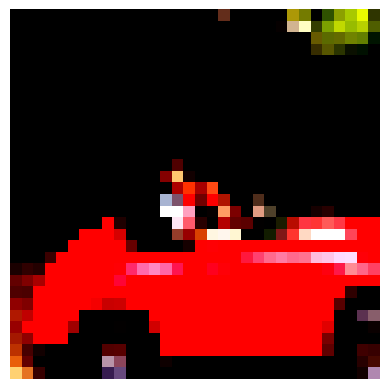

In [137]:
plt.imshow(img_t.permute(1, 2, 0))
plt.axis('off');

In [178]:
label_map = {0: 0, 2: 1}
class_names = ['airplane', 'bird']

cifar2 = [(to_tensor(img), label_map[label]) for img, label in cifar10 if label in [0, 2]]
cifar2_val = [(to_tensor(img), label_map[label]) for img, label in cifar10_val if label in [0, 2]]

In [179]:
n_out = 2

model = nn.Sequential(
    nn.Linear(3072, 512),
    nn.Tanh(),
    nn.Linear(512, n_out),
    nn.Softmax(dim=1)
)

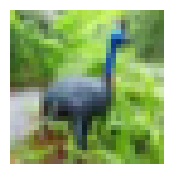

In [180]:
img, _ = cifar2[0]

plt.figure(figsize=(2,2))
plt.imshow(img.permute(1, 2, 0))
plt.axis('off');

In [181]:
img_batch = img.view(-1).unsqueeze(0)

out = model(img_batch)
out

tensor([[0.5289, 0.4711]], grad_fn=<SoftmaxBackward0>)

In [182]:
_, index = torch.max(out, dim=1)
index.item()

0

In [187]:
model = nn.Sequential(
             nn.Linear(3072, 512),
             nn.Tanh(),
             nn.Linear(512, 2),
             nn.LogSoftmax(dim=1))

loss_fn = nn.NLLLoss()

In [188]:
img, label = cifar2[0]
out = model(img.view(-1).unsqueeze(0))
loss_fn(out, torch.tensor([label]))

tensor(0.7711, grad_fn=<NllLossBackward0>)

In [204]:
learning_rate = 1e-2
optimizer = optim.SGD(model.parameters(), learning_rate)
n_epochs = 15

for epoch in range(n_epochs):
    for img, label in cifar2:
        out = model(img.view(-1).unsqueeze(0))
        loss = loss_fn(out, torch.tensor([label]))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {epoch} \t Loss: {loss:.3f}') # This is just printing the loss on last image. Not nice

Epoch: 0 	 Loss: 1.565
Epoch: 1 	 Loss: 1.681
Epoch: 2 	 Loss: 1.914
Epoch: 3 	 Loss: 2.237
Epoch: 4 	 Loss: 2.615
Epoch: 5 	 Loss: 2.584
Epoch: 6 	 Loss: 2.643
Epoch: 7 	 Loss: 2.778
Epoch: 8 	 Loss: 2.962
Epoch: 9 	 Loss: 2.844
Epoch: 10 	 Loss: 2.222
Epoch: 11 	 Loss: 2.008
Epoch: 12 	 Loss: 2.037
Epoch: 13 	 Loss: 1.247
Epoch: 14 	 Loss: 2.270


In [205]:
trainloader = torch.utils.data.DataLoader(cifar2, batch_size=64, shuffle=True)

for epoch in range(n_epochs):
    for imgs, labels in trainloader:
        batch_size = imgs.shape[0]
        out = model(imgs.view(batch_size, -1))
        loss = loss_fn(out, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print(f'Epoch: {epoch} \t Loss: {loss:.3f}') # Loss is for last batch in each epoch. Not nice either

Epoch: 0 	 Loss: 0.561
Epoch: 1 	 Loss: 0.276
Epoch: 2 	 Loss: 0.622
Epoch: 3 	 Loss: 0.666
Epoch: 4 	 Loss: 0.417
Epoch: 5 	 Loss: 0.376
Epoch: 6 	 Loss: 0.228
Epoch: 7 	 Loss: 0.334
Epoch: 8 	 Loss: 0.297
Epoch: 9 	 Loss: 0.474
Epoch: 10 	 Loss: 0.178
Epoch: 11 	 Loss: 0.346
Epoch: 12 	 Loss: 0.266
Epoch: 13 	 Loss: 0.357
Epoch: 14 	 Loss: 0.271


In [198]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64, shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        batch_size = imgs.shape[0]
        out = model(imgs.view(batch_size, -1))

        _, predicted = torch.max(out, dim=1)
        total += labels.shape[0]
        correct += int((predicted==labels).sum())

    print(f'Accuracy: {correct/total}')

Accuracy: 0.8175


In [201]:
model = nn.Sequential(
            nn.Linear(3072, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 128),
            nn.Tanh(),
            nn.Linear(128, 2))

learning_rate = 1e-2

optimizer = optim.SGD(model.parameters(), lr=learning_rate)

loss_fn = nn.CrossEntropyLoss()

n_epochs = 5

for epoch in range(n_epochs):
    for imgs, labels in trainloader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("Epoch: %d, Loss: %f" % (epoch, float(loss)))

Epoch: 0, Loss: 0.449910
Epoch: 1, Loss: 0.596678
Epoch: 2, Loss: 0.608984
Epoch: 3, Loss: 0.536350
Epoch: 4, Loss: 0.628276


In [202]:
train_loader = torch.utils.data.DataLoader(cifar2, batch_size=64,
                                           shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in train_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.626600


In [203]:
val_loader = torch.utils.data.DataLoader(cifar2_val, batch_size=64,
                                         shuffle=False)

correct = 0
total = 0

with torch.no_grad():
    for imgs, labels in val_loader:
        outputs = model(imgs.view(imgs.shape[0], -1))
        _, predicted = torch.max(outputs, dim=1)
        total += labels.shape[0]
        correct += int((predicted == labels).sum())
        
print("Accuracy: %f" % (correct / total))

Accuracy: 0.631000


In [207]:
numel_list = [p.numel() for p in model.parameters() if p.requires_grad==True]
sum(numel_list), numel_list

(3737474, [3145728, 1024, 524288, 512, 65536, 128, 256, 2])

#### Corollary: Understanding `torch.stack`

In [84]:
def create_tensor(start):
    return torch.tensor([[[start, start + 1], [start + 2, start + 3]],
                         [[start + 4, start + 5], [start + 6, start + 7]],
                         [[start + 8, start + 9], [start + 10, start + 11]]])

sub_i1 = create_tensor(1)
sub_i2 = create_tensor(12)
sub_i3 = create_tensor(23)
sub_i4 = create_tensor(34)

In [85]:
sub_i1, sub_i2, sub_i3, sub_i4

(tensor([[[ 1,  2],
          [ 3,  4]],
 
         [[ 5,  6],
          [ 7,  8]],
 
         [[ 9, 10],
          [11, 12]]]),
 tensor([[[12, 13],
          [14, 15]],
 
         [[16, 17],
          [18, 19]],
 
         [[20, 21],
          [22, 23]]]),
 tensor([[[23, 24],
          [25, 26]],
 
         [[27, 28],
          [29, 30]],
 
         [[31, 32],
          [33, 34]]]),
 tensor([[[34, 35],
          [36, 37]],
 
         [[38, 39],
          [40, 41]],
 
         [[42, 43],
          [44, 45]]]))

In [86]:
sub_stacked = torch.stack([sub_i1, sub_i2, sub_i3, sub_i4], dim=3)
sub_stacked

tensor([[[[ 1, 12, 23, 34],
          [ 2, 13, 24, 35]],

         [[ 3, 14, 25, 36],
          [ 4, 15, 26, 37]]],


        [[[ 5, 16, 27, 38],
          [ 6, 17, 28, 39]],

         [[ 7, 18, 29, 40],
          [ 8, 19, 30, 41]]],


        [[[ 9, 20, 31, 42],
          [10, 21, 32, 43]],

         [[11, 22, 33, 44],
          [12, 23, 34, 45]]]])

In [87]:
sub_stacked.view(3, -1)

tensor([[ 1, 12, 23, 34,  2, 13, 24, 35,  3, 14, 25, 36,  4, 15, 26, 37],
        [ 5, 16, 27, 38,  6, 17, 28, 39,  7, 18, 29, 40,  8, 19, 30, 41],
        [ 9, 20, 31, 42, 10, 21, 32, 43, 11, 22, 33, 44, 12, 23, 34, 45]])

#### Corollary: Visualizing sigmoid and derivatives

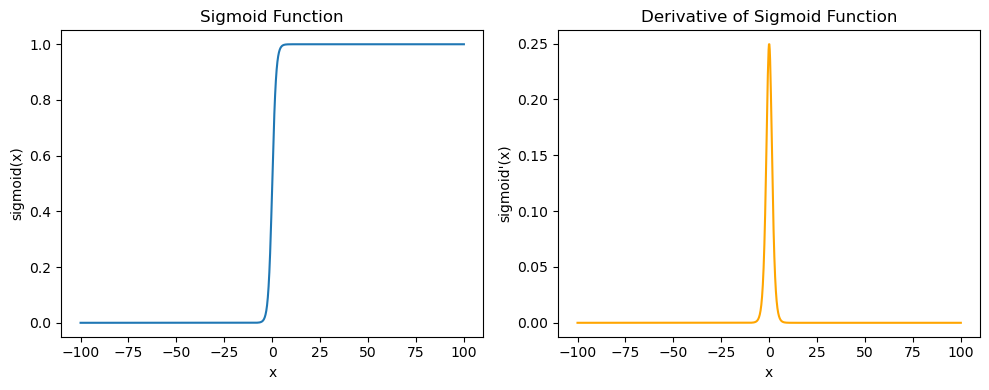

In [131]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define the derivative of the sigmoid function
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Create a range of values from -100 to 100
x_values = np.linspace(-100, 100, 1000)

# Calculate the sigmoid for each x value
y_values_sigmoid = sigmoid(x_values)

# Calculate the derivative of the sigmoid for each x value
y_values_derivative = sigmoid_derivative(x_values)

# Plotting
plt.figure(figsize=(10, 4))

# Plot sigmoid
plt.subplot(1, 2, 1)
plt.plot(x_values, y_values_sigmoid, label='Sigmoid')
plt.title('Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid(x)')

# Plot derivative of sigmoid
plt.subplot(1, 2, 2)
plt.plot(x_values, y_values_derivative, label='Derivative of Sigmoid', color='orange')
plt.title('Derivative of Sigmoid Function')
plt.xlabel('x')
plt.ylabel('sigmoid\'(x)')

plt.tight_layout()
plt.show()


#### Corollary: Visualzing min-max and standard scaling

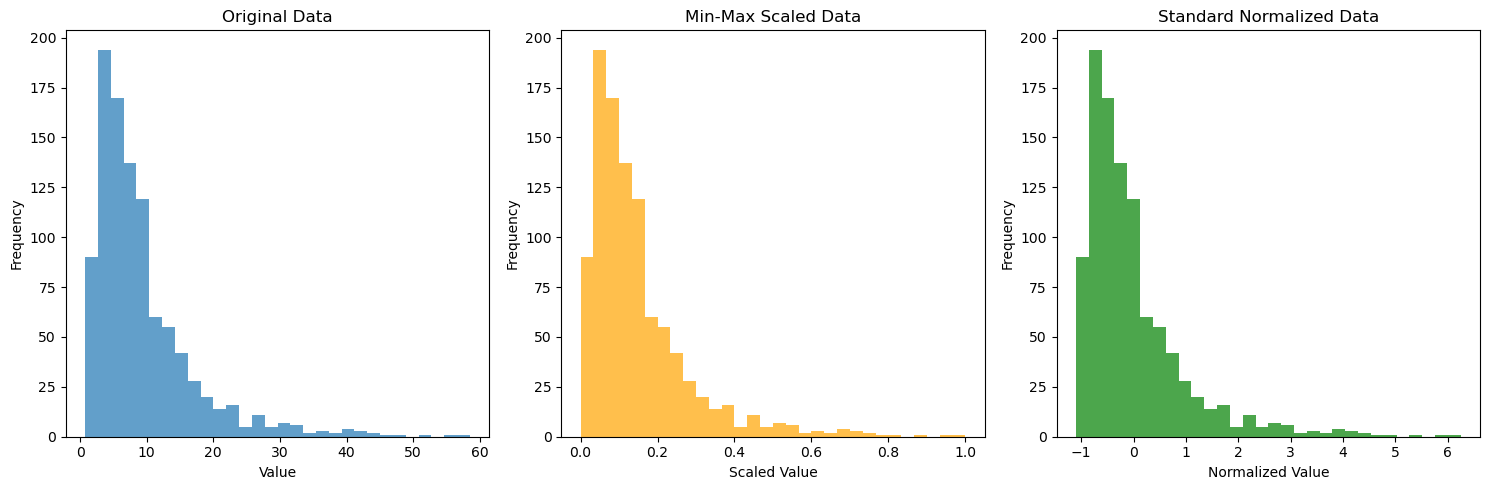

In [133]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Generate a sample dataset
np.random.seed(0)
data = np.random.lognormal(mean=2., sigma=0.75, size=(1000, 1))

# Min-Max scaling
scaler_min_max = MinMaxScaler()
data_scaled = scaler_min_max.fit_transform(data)

# Standard scaling (normalizing)
scaler_standard = StandardScaler()
data_normalized = scaler_standard.fit_transform(data)

# Plotting
plt.figure(figsize=(15, 5))

# Original data
plt.subplot(1, 3, 1)
plt.hist(data, bins=30, alpha=0.7, label='Original')
plt.title('Original Data')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Scaled data
plt.subplot(1, 3, 2)
plt.hist(data_scaled, bins=30, alpha=0.7, label='Scaled', color='orange')
plt.title('Min-Max Scaled Data')
plt.xlabel('Scaled Value')
plt.ylabel('Frequency')

# Normalized data
plt.subplot(1, 3, 3)
plt.hist(data_normalized, bins=30, alpha=0.7, label='Normalized', color='green')
plt.title('Standard Normalized Data')
plt.xlabel('Normalized Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()
